# Volatility forecasting (GARCH & ARCH)

> In this example, we'll forecast the volatility of the S&P 500 and several publicly traded companies using GARCH and ARCH models

::: {.callout-warning collapse="true"}

## Prerequesites

This tutorial assumes basic familiarity with StatsForecast. For a minimal example visit the [Quick Start](https://nixtla.github.io/statsforecast/examples/getting_started_short.html) 
:::

## Introduction 

The Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model is used for time series that exhibit non-constant volatility over time. Here volatility refers to the conditional standard deviation. The GARCH(p,q) model is given by 

\begin{equation}
y_t = v_t \sigma_t 
\end{equation}

where $v_t$ is independent and identically distributed with zero mean and unit variance, and $\sigma_t$ evolves according to 

\begin{equation}
\sigma_t^2 = w + \sum_{i=1}^p \alpha_i y^2_{t-i} + \sum_{j=1}^q \beta_j \sigma_{t-j}^2
\end{equation}

The coefficients in the equation above must satisfy the following conditions: 

1. $w>0$, $\alpha_i \geq 0$ for all $i$, and $\beta_j \geq 0$ for all $j$ 
2. $\sum_{k=1}^{max(p,q)} \alpha_k + \beta_k < 1$. Here it is assumed that $\alpha_i=0$ for $i>p$ and $\beta_j=0$ for $j>q$. 

A particular case of the GARCH model is the ARCH model, in which $q=0$. Both models are commonly used in finance to model the volatility of stock prices, exchange rates, interest rates, and other financial instruments. They're also used in risk management to estimate the probability of large variations in the price of financial assets. 

By the end of this tutorial, you'll have a good understanding of how to implement a GARCH or an ARCH model in [StatsForecast](https://nixtla.github.io/statsforecast/) and how they can be used to analyze and predict financial time series data. 

**Outline:**

1. Install libraries 
2. Load and explore the data
3. Train models 
4. Perform time series cross-validation 
5. Evaluate results 
6. Forecast volatility 

::: {.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/examples/GARCH_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
::: 

## Install libraries 

We assume that you have StatsForecast already installed. If not, check this guide for instructions on [how to install StatsForecast](https://nixtla.github.io/statsforecast/examples/installation.html) 

Install the necessary packages using `pip install statsforecast`

In [ ]:
%%capture
pip install statsforecast -U

## Load and explore the data



In this tutorial, we'll use the last 5 years of prices from the S&P 500 and several publicly traded companies. The data can be downloaded from Yahoo! Finance using [yfinance](https://github.com/ranaroussi/yfinance). To install it, use `pip install yfinance`. 

In [ ]:
%%capture
pip install yfinance 

We'll also need `pandas` to deal with the dataframes. 

In [ ]:
import yfinance as yf
import pandas as pd 

tickers = ['SPY', 'MSFT', 'AAPL', 'GOOG', 'AMZN', 'TSLA', 'NVDA', 'META', 'NKE', 'NFLX'] 
df = yf.download(tickers, start = '2018-01-01', end = '2022-12-31', interval='1mo') # use monthly prices
df.head()

[*********************100%***********************]  10 of 10 completed


Adj Close                                               \
                 AAPL       AMZN       GOOG        META       MSFT   
Date                                                                 
2018-01-01  39.741600  72.544502  58.497002  186.889999  89.248795   
2018-02-01  42.279003  75.622498  55.236500  178.320007  88.083977   
2018-03-01  39.987049  72.366997  51.589500  159.789993  86.138306   
2018-04-01  39.386456  78.306503  50.866501  172.000000  88.261772   
2018-05-01  44.536774  81.481003  54.249500  191.779999  93.282684   

                                                                     ...  \
                  NFLX        NKE       NVDA         SPY       TSLA  ...   
Date                                                                 ...   
2018-01-01  270.299988  64.929794  60.830006  258.821716  23.620667  ...   
2018-02-01  291.380005  63.797192  59.889587  249.410843  22.870667  ...   
2018-03-01  295.350006  63.235634  57.348972  241.606735  17.742001  ...   
2018-04-01  312.459991  65.288483  55.692307  243.828094  19.593332  ...   
2018-05-01  351.600006  68.543831  62.450188  249.755310  18.982000  ...   

                Volume                                               \
                  AAPL        AMZN       GOOG       META       MSFT   
Date                                                                  
2018-01-01  2638717600  1927424000  574768000  495655700  574258400   
2018-02-01  3711577200  2755680000  847640000  516251600  725663300   
2018-03-01  2854910800  2608002000  907066000  996201700  750754800   
2018-04-01  2664617200  2598392000  834318000  750072700  668130700   
2018-05-01  2483905200  1432310000  636988000  401144100  509417900   

                                                                      
                 NFLX        NKE        NVDA         SPY        TSLA  
Date                                                                  
2018-01-01  238377600  157812200  1145621600  1985506700  1864072500  
2018-02-01  184585800  160317000  1491552800  2923722000  1637850000  
2018-03-01  263449400  174066700  1411844000  2323561800  2359027500  
2018-04-01  262006000  158981900  1114400800  1998466500  2854662000  
2018-05-01  142050800  129566300  1197824000  1606397200  2333671500  

[5 rows x 60 columns]

The data downloaded includes different prices. We'll use the [adjusted closing price](https://help.yahoo.com/kb/SLN28256.html#:~:text=Adjusted%20close%20is%20the%20closing,Security%20Prices%20(CRSP)%20standards.), which is the closing price after accounting for any corporate actions like stock splits or dividend distributions. It is also the price that is used to examine historical returns.

Notice that the dataframe that `yfinance` returns has a [MultiIndex](https://pandas.pydata.org/docs/user_guide/advanced.html), so we need to select both the adjusted price and the tickers. 

In [ ]:
df = df.loc[:, (['Adj Close'], tickers)]
df.columns = df.columns.droplevel() # drop MultiIndex
df = df.reset_index()
df.head()

Date         SPY       MSFT       AAPL       GOOG       AMZN  \
0 2018-01-01  258.821716  89.248795  39.741600  58.497002  72.544502   
1 2018-02-01  249.410843  88.083977  42.279003  55.236500  75.622498   
2 2018-03-01  241.606735  86.138306  39.987049  51.589500  72.366997   
3 2018-04-01  243.828094  88.261772  39.386456  50.866501  78.306503   
4 2018-05-01  249.755310  93.282684  44.536774  54.249500  81.481003   

        TSLA       NVDA        META        NKE        NFLX  
0  23.620667  60.830006  186.889999  64.929794  270.299988  
1  22.870667  59.889587  178.320007  63.797192  291.380005  
2  17.742001  57.348972  159.789993  63.235634  295.350006  
3  19.593332  55.692307  172.000000  65.288483  312.459991  
4  18.982000  62.450188  191.779999  68.543831  351.600006

The input to StatsForecast is a dataframe in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds` and `y`: 

- `unique_id`: (string, int or category) A unique identifier for the series.
- `ds`: (datestamp or int) A datestamp in format YYYY-MM-DD or YYYY-MM-DD HH:MM:SS or an integer indexing time.
- `y`: (numeric) The measurement we wish to forecast.

Hence, we need to reshape the data. We'll do this by creating a new dataframe called `price`. 

In [ ]:
prices = df.melt(id_vars = 'Date')
prices = prices.rename(columns={'Date': 'ds', 'variable': 'unique_id', 'value': 'y'})
prices = prices[['unique_id', 'ds', 'y']]
prices

unique_id         ds           y
0         SPY 2018-01-01  258.821716
1         SPY 2018-02-01  249.410843
2         SPY 2018-03-01  241.606735
3         SPY 2018-04-01  243.828094
4         SPY 2018-05-01  249.755310
..        ...        ...         ...
595      NFLX 2022-08-01  223.559998
596      NFLX 2022-09-01  235.440002
597      NFLX 2022-10-01  291.880005
598      NFLX 2022-11-01  305.529999
599      NFLX 2022-12-01  294.880005

[600 rows x 3 columns]

We can plot this series using the `plot` method of the StatsForecast class. 

In [ ]:
from statsforecast import StatsForecast 

/home/ubuntu/miniconda/envs/statsforecast/lib/python3.10/site-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


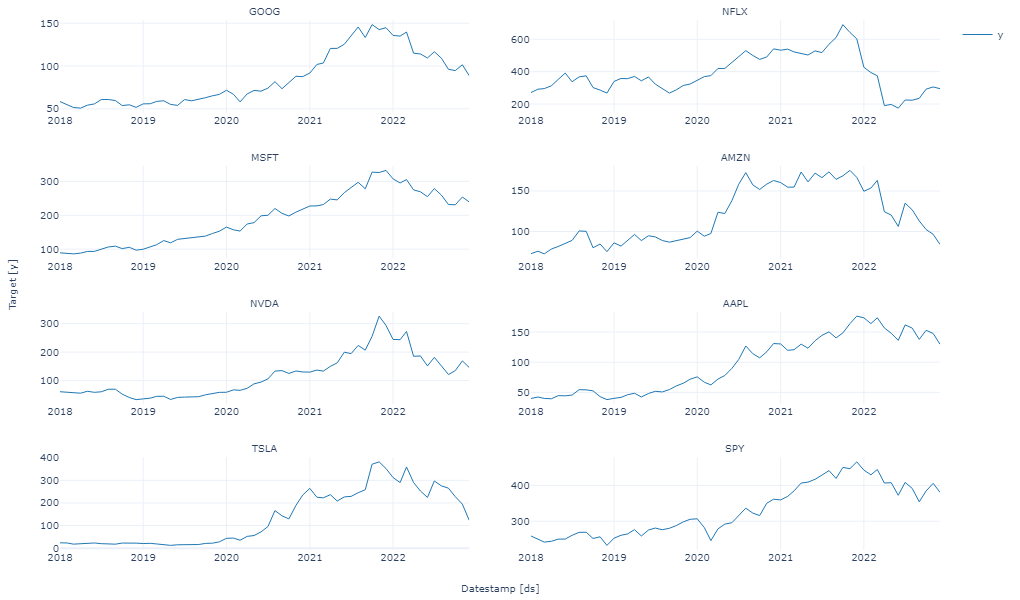

In [ ]:
StatsForecast.plot(prices)

With the prices, we can compute the logarithmic returns of the S&P 500 and the publicly traded companies. This is the variable we're interested in since it's likely to work well with the GARCH framework. The logarithmic return is given by 

$return_t = log \big( \frac{price_t}{price_{t-1}} \big)$

We'll compute the returns on the price dataframe and then we'll create a return dataframe with StatsForecast's format. To do this, we'll need `numpy`. 

In [ ]:
import numpy as np 
prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1))
prices['rt'] = np.log(prices['rt'])

returns = prices[['unique_id', 'ds', 'rt']]
returns = returns.rename(columns={'rt':'y'})
returns 

unique_id         ds         y
0         SPY 2018-01-01       NaN
1         SPY 2018-02-01 -0.037038
2         SPY 2018-03-01 -0.031790
3         SPY 2018-04-01  0.009152
4         SPY 2018-05-01  0.024018
..        ...        ...       ...
595      NFLX 2022-08-01 -0.005976
596      NFLX 2022-09-01  0.051776
597      NFLX 2022-10-01  0.214887
598      NFLX 2022-11-01  0.045705
599      NFLX 2022-12-01 -0.035479

[600 rows x 3 columns]

::: {.callout-warning}

If the order of the data is very small (say $<1e-5$), `scipy.optimize.minimize` might not terminate successfully. In this case, transform the data to a higher order, generate the GARCH or ARCH model, and then transform the data back. 

:::


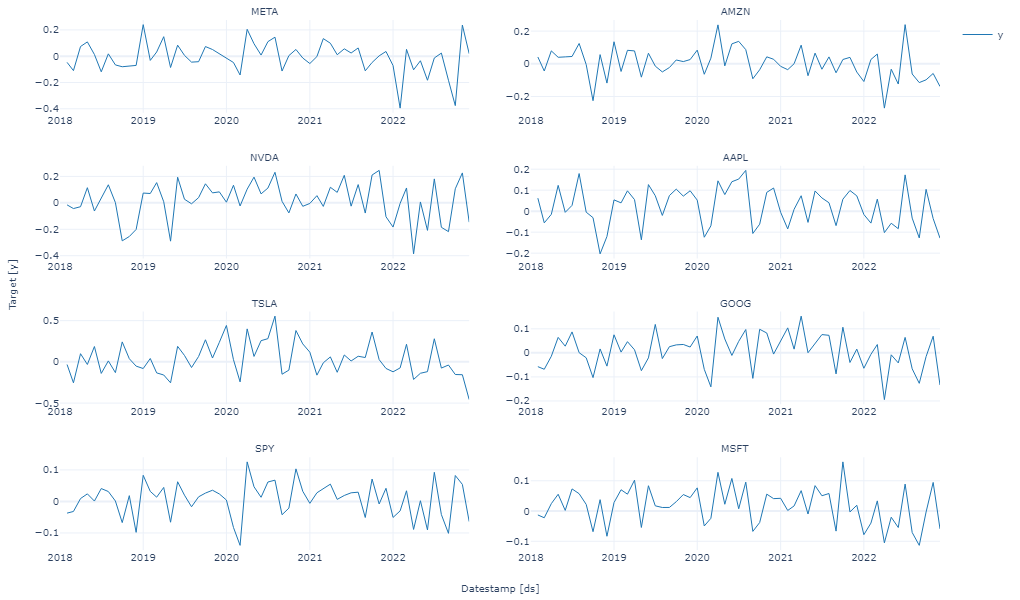

In [ ]:
StatsForecast.plot(returns)

From this plot, we can see that the returns seem suited for the GARCH framework, since large shocks _tend_ to be followed by other large shocks. This doesn't mean that after every large shock we should expect another one; merely that the probability of a large variance is greater than the probability of a small one. 

## Train models

We first need to import the [GARCH](https://nixtla.github.io/statsforecast/models.html) and the [ARCH](https://nixtla.github.io/statsforecast/models.html) models from `statsforecast.models`, and then we need to fit them by instantiating a new StatsForecast object. Notice that we'll be using different values of $p$ and $q$. In the next section, we'll determine which ones produce the most accurate model using cross-validation. We'll also import the [Naive](https://nixtla.github.io/statsforecast/models.html#naive) model since we'll use it as a baseline. 

In [ ]:
from statsforecast.models import (
    GARCH, 
    ARCH, 
    Naive
)

models = [ARCH(1), 
          ARCH(2), 
          GARCH(1,1),
          GARCH(1,2),
          GARCH(2,2),
          GARCH(2,1),
          Naive()
]

To instantiate a new StatsForecast object, we need the following parameters:

- `df`: The dataframe with the training data.
- `models`: The list of models defined in the previous step.
- `freq`: A string indicating the frequency of the data. Here we'll use **MS**, which correspond to the start of the month. You can see the list of panda's available frequencies [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases). 
- `n_jobs`: An integer that indicates the number of jobs used in parallel processing. Use -1 to select all cores.

In [ ]:
sf = StatsForecast(
    df = returns, 
    models = models, 
    freq = 'MS',
    n_jobs = -1
)

## Perform time series cross-validation

Time series cross-validation is a method for evaluating how a model would have performed in the past. It works by defining a sliding window across the historical data and predicting the period following it. Here we'll use StatsForercast's `cross-validation` method to determine the most accurate model for the S&P 500 and the companies selected. 

This method takes the following arguments: 

- `df`: The dataframe with the training data. 
- `h` (int): represents the h steps into the future that will be forecasted.
- `step_size` (int): step size between each window, meaning how often do you want to run the forecasting process.
- `n_windows` (int): number of windows used for cross-validation, meaning the number of forecasting processes in the past you want to evaluate.

For this particular example, we'll use 4 windows of 3 months, or all the quarters in a year. 

In [ ]:
crossvalidation_df = sf.cross_validation(
    df = returns,
    h = 3,
    step_size = 3,
    n_windows = 4
  )

The `crossvalidation_df` object ia a dataframe with the following columns: 

- `unique_id`: index. 
- `ds`: datestamp or temporal index
- `cutoff`: the last datestamp or temporal index for the `n_windows`.
- `y`: true value
- `"model"`: columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df.head()

unique_id         ds     cutoff    actual   ARCH(1)   ARCH(2)  GARCH(1,1)  \
0      AAPL 2022-01-01 2021-12-01 -0.015837  0.142419  0.211340    0.142959   
1      AAPL 2022-02-01 2021-12-01 -0.056856 -0.056896 -0.080954   -0.056388   
2      AAPL 2022-03-01 2021-12-01  0.057156 -0.045900 -0.069933   -0.047514   
3      AAPL 2022-04-01 2022-03-01 -0.102178  0.138656  0.140217    0.136210   
4      AAPL 2022-05-01 2022-03-01 -0.057505 -0.056012 -0.056266   -0.054598   

   GARCH(1,2)  GARCH(2,2)  GARCH(2,1)     Naive  
0    0.141684    0.239815    0.144009  0.073061  
1   -0.058787   -0.092342   -0.057158  0.073061  
2   -0.045712   -0.079878   -0.046476  0.073061  
3    0.136124    0.136122    0.140219  0.057156  
4   -0.057077   -0.057080   -0.056269  0.057156

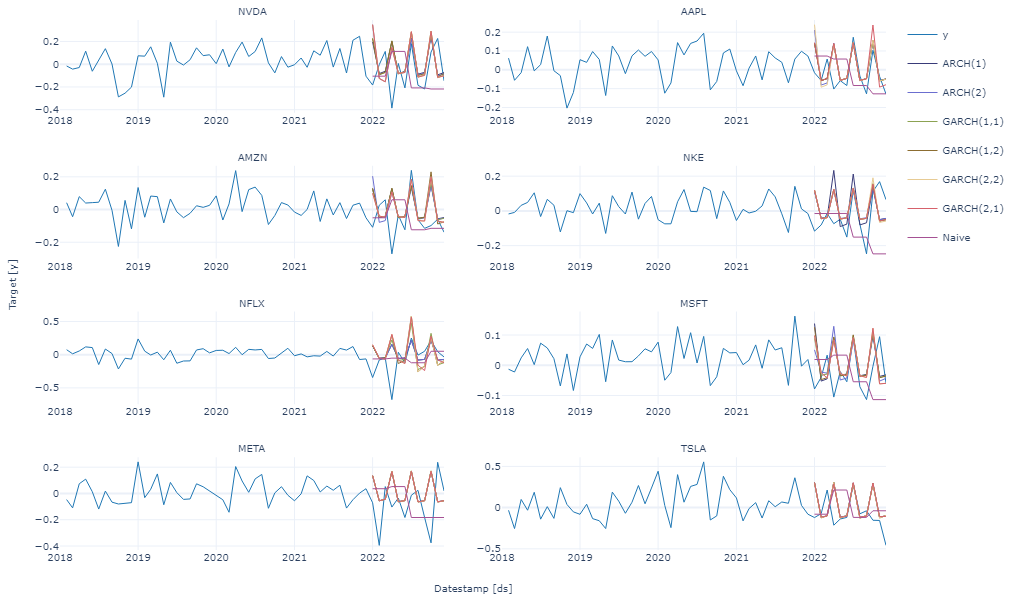

In [ ]:
StatsForecast.plot(returns, crossvalidation_df.drop(['cutoff', 'actual'], axis=1))

A tutorial on cross-validation can be found [here](https://nixtla.github.io/statsforecast/examples/crossvalidation.html). 

## Evaluate results 

To compute the accuracy of the forecasts, we’ll use the mean average error (mae), which is the sum of the absolute errors divided by the number of forecasts. There's an implementation of MAE on [datasetsforecast](https://github.com/Nixtla/datasetsforecast/tree/main/), so we'll install it and then import the mae function. 

In [ ]:
%%capture
pip install datasetsforecast -U 

In [ ]:
from datasetsforecast.losses import mae

The MAE needs to be computed for every window and then it needs to be averaged across all of them. To do this, we'll create the following function. 

In [ ]:
def compute_cv_mae(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: 
        res[mod] = mae(crossvalidation_df['actual'], crossvalidation_df[str(mod)])
    return pd.Series(res)

In [ ]:
mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)

mae = mae_cv.groupby('unique_id').mean()
mae.style.highlight_min(color = 'lightblue', axis = 1)

Hence, the most accurate model to describe the logarithmic returns of Apple's stock is a ARCH(1), for Amazon is GARCH(2,1), and so on. 

## Forecast volatility 

We can now generate a forecast for the next quarter. To do this, we'll use the `forecast` method, which requieres the following arguments:

- `h`: (int) The forecasting horizon.
- `level`: (list[float]) The confidence levels of the prediction intervals
- `fitted` : (bool = False) Returns insample predictions.

In [ ]:
levels = [80, 95] # confidence levels for the prediction intervals 

forecasts = sf.forecast(h=3, level=levels)
forecasts = forecasts.reset_index()
forecasts.head()

unique_id         ds   ARCH(1)  ARCH(1)-lo-95  ARCH(1)-lo-80  ARCH(1)-hi-80  \
0      AAPL 2023-01-01  0.150458       0.133642       0.139462       0.161453   
1      AAPL 2023-02-01 -0.056943      -0.073924      -0.068046      -0.045839   
2      AAPL 2023-03-01 -0.048391      -0.064842      -0.059148      -0.037633   
3      AMZN 2023-01-01  0.152158       0.134960       0.140913       0.163404   
4      AMZN 2023-02-01 -0.057306      -0.074504      -0.068551      -0.046060   

   ARCH(1)-hi-95   ARCH(2)  ARCH(2)-lo-95  ARCH(2)-lo-80  ...  GARCH(2,1)  \
0       0.167274  0.150159       0.133410       0.139207  ...    0.147603   
1      -0.039962 -0.057203      -0.074339      -0.068408  ...   -0.059509   
2      -0.031939 -0.049273      -0.066330      -0.060426  ...   -0.054534   
3       0.169357  0.148659       0.132243       0.137925  ...    0.148597   
4      -0.040107 -0.061187      -0.080794      -0.074007  ...   -0.069302   

   GARCH(2,1)-lo-95  GARCH(2,1)-lo-80  GARCH(2,1)-hi-80  GARCH(2,1)-hi-95  \
0          0.131419          0.137021          0.158185          0.163786   
1         -0.078055         -0.071635         -0.047382         -0.040963   
2         -0.075429         -0.068197         -0.040872         -0.033640   
3          0.132195          0.137872          0.159322          0.165000   
4         -0.094455         -0.085749         -0.052856         -0.044150   

      Naive  Naive-lo-80  Naive-lo-95  Naive-hi-80  Naive-hi-95  
0 -0.128762    -0.284463    -0.366886     0.026939     0.109363  
1 -0.128762    -0.348956    -0.465520     0.091433     0.207997  
2 -0.128762    -0.398444    -0.541205     0.140920     0.283681  
3 -0.139141    -0.315716    -0.409190     0.037435     0.130909  
4 -0.139141    -0.388856    -0.521048     0.110575     0.242767  

[5 rows x 37 columns]

With the results of the previous section, we can choose the best model for the S&P 500 and the companies selected. Some of the plots are shown below. Notice that we're using somo additional arguments in the `plot` method: 

- `level`: (list[int]) The confidence levels for the prediction intervals (this was already defined). 
- `unique_ids`: (list[str, int or category]) The ids to plot. 
- `models`: (list(str)). The model to plot. In this case, is the model selected by cross-validation.

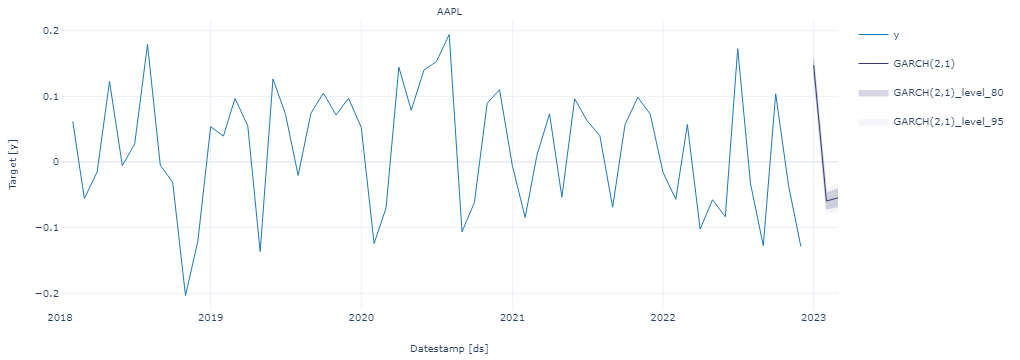

In [ ]:
StatsForecast.plot(returns, forecasts, level=levels, unique_ids = ['AAPL'], models = ['GARCH(2,1)'])

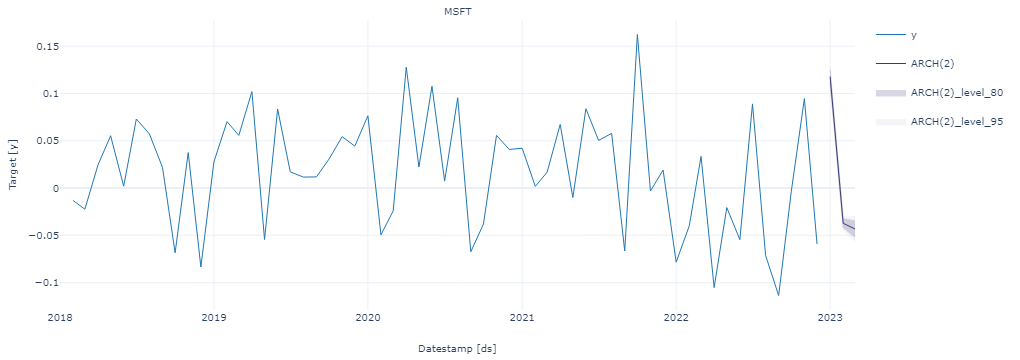

In [ ]:
StatsForecast.plot(returns, forecasts, level=levels, unique_ids = ['MSFT'], models = ['ARCH(2)'])

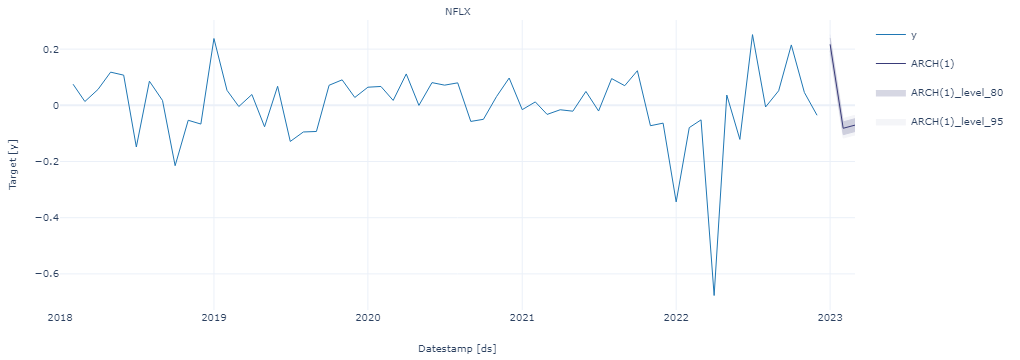

In [ ]:
StatsForecast.plot(returns, forecasts, level=levels, unique_ids = ['NFLX'], models = ['ARCH(1)'])

### Revert back to prices 

In the previous section, we generated a forecast for the returns $r_t$. If you want the prices, then we need to transform back the data. In this case, this is done as follows. 

$r_t = log \big( \frac{p_t}{p_{t-1}} \big) \implies p_t = exp(r_t)*p_{t-1} $

Notice that this formula is recursive, so we'll need the last historical price. Below is an example for AAPL, who was assigned an ARCH(1) model. 

In [ ]:
last_price = prices[prices['unique_id'] == 'AAPL']['y'].tail(1)

aapl = forecasts[forecasts['unique_id'] == 'AAPL']
aapl = aapl[['unique_id', 'ds', 'ARCH(1)']]
price_fcst = np.full(len(aapl), fill_value = np.nan)

for k in range(len(price_fcst)): 
    if k == 0: 
        price_fcst[k] = np.exp(aapl['ARCH(1)'][k])*last_price 
    else: 
        price_fcst[k] = np.exp(aapl['ARCH(1)'][k])*price_fcst[k-1]

aapl['price_fcst'] = price_fcst.tolist()
aapl

unique_id         ds   ARCH(1)  price_fcst
0      AAPL 2023-01-01  0.150458  150.795991
1      AAPL 2023-02-01 -0.056943  142.449144
2      AAPL 2023-03-01 -0.048391  135.720073

Keep in mind that this can be done for the point forecasts. If you need prediction intervals, then it might be better to forecast the original series. 

## References 

- [Engle, R. F. (1982). Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation. Econometrica: Journal of the econometric society, 987-1007.](http://www.econ.uiuc.edu/~econ508/Papers/engle82.pdf) 

- [Bollerslev, T. (1986). Generalized autoregressive conditional heteroskedasticity. Journal of econometrics, 31(3), 307-327.](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=7da8bfa5295375c1141d797e80065a599153c19d)

- [Hamilton, J. D. (1994). Time series analysis. Princeton university press.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)

- [Tsay, R. S. (2005). Analysis of financial time series. John wiley & sons.](https://www.wiley.com/en-us/Analysis+of+Financial+Time+Series%2C+3rd+Edition-p-9780470414354)